# Structural Analysis pipeline for RNAI libraries
#### M. Werner - v.01 (11/23)

The loops of the hairpins in the RNAI play a crucial role in binding RNAII. These hairpins were already sampled with different seq lengths, however what influence different sizes of stem or loops have. Therefore this analysis is to filter sequences with interesting stem/loop structures.

<a id='xfg'></a>
## Contents
__Functions to prepare NGS data__
* [Packages needed](#packages)
* [functions to prepare data](#preparation)
* [LoopI parameters](#LoopI_parameter)
* [add RNA structure](#add_structure)
* [loop & stem ranges](#ranges)

__Starting the Analysis of loop and stem__

__-> different length Stem__
* [create a search set for the Stem + filter seq that match](#searchset_stem)

__-> different length Loop__
* [create a search set for the Loop + filter seq that match](#searchset_loop)

__-> relative length Hairpin__
* [calculating the relative lengths of the WT structure & NGS data + implementing in dataframe](#relative_WTStructure)
* [filter the seq that have a similar relative structure as the WT](#relative_filterSimilar)
* [mapping the diversity of the structures + assigning the seq_number to the structure accordingly](#relative_structAssign)


<a id='packages'></a>

In [1]:
using Pkg
Pkg.activate("/Users/marlenewerner/Desktop/Diplom/Code for Analysis/RNA_structure_loops/L1_medium2")

  Activating new project at `~/Desktop/Diplom/Code for Analysis/RNA_structure_loops/L1_medium2`


In [5]:
## Packages needed to run the data clean up
using DataFrames
using CSV
using FASTX
using BioAlignments
using BioSequences
using Random
using StatsBase
using StatsPlots
using Combinatorics
using ViennaRNA
using Unitful
using Clustering
using PlotRNA
using DelimitedFiles

<a id='preparation'></a>

In [6]:
file_name = "Old_medium_Loop1_rc.fasta"

"Old_medium_Loop1_rc.fasta"

In [7]:
## All functions are summarised here for clarity and code efficiency

# Load FASTA file as an Array of String
function load_fasta_file(file_name::String)
    R0 = []
    reader = FASTA.Reader(open(file_name, "r"))
    for record in reader
        push!(R0, convert(String, FASTA.sequence(record)))
    end
    close(reader)
    return R0
end

# Uses string patterns to isolate LoopI relevant sequences
function isolate_hairpin(File::String, upstream::String, downstream::String)
    full_seq = []
    all_seq = load_fasta_file(File)

    for n = 1:size(all_seq, 1)
        if occursin(upstream, all_seq[n]) && occursin(downstream, all_seq[n]) # looks for sequences that have both sequences
            edge1 = findfirst(upstream, all_seq[n])[end] # finds the beginning of stem 1
            edge2 = findfirst(downstream, all_seq[n])[1] # finds the end of stem 1
            # the processing above must always be checked to ensure single base duplication or
            # deletion is not being accidentally introduced 
    
            new_seq = all_seq[n][edge1:edge2]
            if new_seq != ""
                push!(full_seq, new_seq) # pushes non-empty sequences into a set
            end
        end
    end

    return full_seq
end    

# used to convert individual NGS reads into a table containing the counts of individual sequences
function instance_to_count(library, wild_type)
    # Converts the data to a dictionary to allow de-duplication
    NGS_processing = Dict{String, Int64}()
    NGS_clean = DataFrame([[],[],[],[], []],["Sequence_number", "LoopI", "Loop_length", "Count", "WT"])

    for i = 1: size(library, 1) # de-duplication process
        if haskey(NGS_processing, library[i])
            NGS_processing[library[i]] += 1
        else
            NGS_processing[library[i]] = 1
        end
    end

    # Remaps the dictionary to a DataFrame for subsequent analysis
    for (key, value) ∈ NGS_processing   # converts dictionary to DataFrame
        entry = DataFrame([[0], [key], [length(key)], [value], ["false"]], ["Sequence_number", "LoopI", "Loop_length", "Count", "WT"])
        append!(NGS_clean, entry)
    end
    
    sort!(NGS_clean, :Count, rev=true)
    
    ## Identifies the WT sequence
    for n = 1:size(NGS_clean, 1)
    NGS_clean.Sequence_number[n] = n
        if NGS_clean.LoopI[n] == wild_type
            NGS_clean.WT[n] = "WT"
        end
    end
    
    return NGS_clean
end

# Generates all possible variants within a given Hamming distance
function hamming(sequence::String, distance::Int)
    output = [] # creates a space for output
    new_entry = []
    bases = ['A', 'C', 'G', 'T']
   

    # calculating all sequences to be searched
    positions = collect(combinations(collect(UnitRange(1, length(sequence))), distance)) # generates all the positions
    variants = collect(multiset_permutations(bases, [distance,distance,distance,distance], distance)) # generates all the nucleobase variants

    for i = 1: size(positions, 1)
        for j = 1: size(variants, 1)
            new_entry = collect(sequence)
            for x = 1: distance
                new_entry[positions[i][x]] = variants[j][x]
            end
            push!(output, join(new_entry))
        end
    end


    #return output
    return unique(output)
end

# Takes the processed NGS DataFrame and uses a frequency-based algorithm to remove possible sequencing errors
# and the wild-type from the DataFrame
function clustering_errors(start_library, wildtype, subst_rate)
    for i = 1: size(start_library, 1)
        if start_library.WT[i] == "WT"
            seed_seq = start_library.Sequence_number[i]
            close_neighbour = hamming(wildtype, 1)
        
            for j = (seed_seq+1): size(start_library, 1)
                if start_library.LoopI[j] ∈ close_neighbour && start_library.Count[j] <= (subst_rate * start_library.Count[seed_seq]) 
                    start_library.WT[j] = "counted"
                    start_library.Count[seed_seq] += start_library.Count[j]
                end
            end
        
        elseif start_library.WT[i] == "false" && start_library.Count[i] * subst_rate >= 1.0
            seed_seq = start_library.Sequence_number[i]
            close_neighbour = hamming(start_library.LoopI[i], 1)
        
            for j = seed_seq+1:size(start_library, 1)
                if start_library.LoopI[j] ∈ close_neighbour && start_library.Count[j] <= (subst_rate * start_library.Count[seed_seq]) 
                    start_library.WT[j] = "counted"
                    start_library.Count[seed_seq] += start_library.Count[j]
                end
            end
        end
    end

    Clustered = filter(:WT => x -> x == "false", start_library)
    return Clustered
end  

clustering_errors (generic function with 1 method)

<a id='LoopI_parameter'></a>

In [8]:
## Loop1 parameters
upstream = "CGTAATCTGCTGCTTGCAAA"
downstream = "CGGATCAAGAG"
wildtype = "ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCC"
WT_structure = ".((((.((((((((((.....)))))))))).))))."
wild_type_pattern = "1-4-1-10-5-10-1-4-1"

"1-4-1-10-5-10-1-4-1"

In [9]:
## Loading the folding parameters for ViennaRNA
ViennaRNA.params_load_RNA_Langdon2018()

## Sequence missing from LoopI to generate the full-length RNAI
downstream_RNAI = "GGATCAAGAGCTACCAACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCAAATACTGT"

"GGATCAAGAGCTACCAACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCAAATACTGT"

<a id='add_structure'></a>

In [10]:
## All functions are summarised here for clarity and code efficiency

# generating structural data 
function rna_details(dataframe::DataFrame, downstream::String)
    Loop_structure = DataFrame([String[],String[], Float32[], Float32[]],["LoopI", "MFE_structure","MFE_energy","Mbp_dist"])
    for n = 1: size(dataframe, 1)
        new_loop = dataframe.LoopI[n] * downstream
        new_fold = FoldCompound(new_loop; temperature=37u"°C", uniq_ML=false, circular=false);
        partfn(new_fold)
        new_mfe = mfe(new_fold)
        new_bpdis = mean_bp_distance(new_fold)
        
        push!(Loop_structure, (dataframe.LoopI[n], new_mfe[1], ustrip(new_mfe[2]), new_bpdis))
        finalize(new_fold)
    end
    dataframe = innerjoin(dataframe, Loop_structure, on = :LoopI);
    insertcols!(dataframe, :Seq_Cluster => 0, :Str_Cluster => 0)
    return dataframe
end


rna_details (generic function with 1 method)

<a id='ranges'></a>

In [11]:
## functions listed here for clarity
## function to identify the length of the longest loop and the length of the first stem
function loop_ranges(structure::String, minimal_loop::Int64, motif::Char)
    result = []
    new_range = []
    dot = false
    ## Runs through a sequence identifying stretches of dots
    for n = 1:length(structure)
        if n == length(structure) && dot == true && structure[n] == motif
            push!(new_range, n)
            push!(result, new_range)
        elseif n == length(structure) && dot == false && structure[n] == motif
            new_range = [n]
            push!(new_range, n)
            push!(result, new_range)
        elseif structure[n] == motif && dot == false
            new_range = [n]
            dot = true
        elseif structure[n] == motif && dot == true
            push!(new_range, n)
        elseif structure[n] != motif && dot == true
            push!(result, new_range)
            dot = false
            new_range = []
        end
    end
    
    ## Removes loops that are too small (e.g. bulges)
    for n = size(result, 1):-1:1
        if size(result[n], 1) < minimal_loop
            deleteat!(result, n)
        end
    end
    
    ## Goes through the set of true loops and identifies the underlying ranges of the loops
    ranges = []
    for n in result
        new_seq = []
        for i in n
            new_seq = n[1]:n[end]
        end
        push!(ranges, new_seq)
    end
    
    return ranges
end  



function stem_and_loops(dataset, downstream_RNAI)
    key_feature = DataFrame([[],[], []],["LoopI", "long_stem", "long_loop"])
    for n = 1:size(dataset.LoopI, 1)
        seq = dataset.MFE_structure[n][1:end-length(downstream_RNAI)]
        dots = loop_ranges(seq, 1, '.')
    
        loop_length = 0
        for i in dots
            if length(i) > loop_length
                loop_length = length(i)
            end
        end
    
        stem_open = loop_ranges(seq, 1, '(')
        stem_close = loop_ranges(seq, 1, ')')
    
        stem_length = 0
        for j = 1: size(stem_open, 1)
            if stem_open != [] && stem_close != []
                if stem_open[j][end] < stem_close[1][1]
                    stem_length += length(stem_open[j])
                end
            elseif stem_open != [] && stem_close == []
                stem_length += length(stem_open[j])
            end
        end
    
        push!(key_feature, (dataset.LoopI[n], stem_length, loop_length))
    end
    dataset = innerjoin(dataset, key_feature, on = :LoopI)
    
    return dataset
end

stem_and_loops (generic function with 1 method)

In [12]:
# functions to determin the loop (x) or upperStem (y) length in the LoopI description
function find_y_range(strings::Vector{String31})
    y_values = Set{Int}()

    for str in strings
        # Extract the y value from the string
        match_result = match(r"1-4-1-\d+-(\d+)-\d+-1-4-1", str)
        
        if match_result !== nothing
            y_value = parse(Int, match_result.captures[1])
            push!(y_values, y_value)
        end
    end

    return y_values
end


function find_x_values(input::Union{String, Vector{String}})
    # Create a set to store unique y values
    x_values = Vector{Int}()

    if isa(input, String)
        # If input is a single string, process it directly
        find_x_value(input, x_values)
    elseif isa(input, Vector{String})
        # If input is a vector of strings, process each string
        for str in input
            find_x_value(str, x_values)
        end
    else
        throw(ArgumentError("Input must be a String or Vector{String}"))
    end

    # Return the set of unique x values
    return x_values
end

function find_x_value(str::String, x_values::Vector{Int})
    # Extract the x value from the string using a regular expression
    match_result = match(r"1-4-1-(\d+)-\d+-\d+-1-4-1", str)
    
    # Check if a match was found
    if match_result !== nothing
        # Parse the captured y value as an integer
        x_value = parse(Int, match_result.captures[1])
        if x_value ∉ x_values
            # Add the y value to the set
            push!(x_values, x_value)
        end
    end
end

find_x_value (generic function with 1 method)

## Starting the Analysis of loop and stem

__different length Stem__
* [create a search set for the Stem + filter seq that match](#searchset_stem)

__different length Loop__
* [create a search set for the Loop + filter seq that match](#searchset_loop)

__relative length hairpin__
* [calculating the relative lengths of the WT structure & NGS data + implementing in dataframe](#relative_WTStructure)
* [filter the seq that have a similar relative structure as the WT](#relative_filterSimilar)
* [mapping the diversity of the structures + assigning the seq_number to the structure accordingly](#relative_structAssign)

### Taking the structural data of all Sequences without filter of seq length

In [19]:
current_directory = pwd()
println("Current Working Directory: $current_directory")

Current Working Directory: /Users/marlenewerner/Desktop/Diplom/Code for Analysis/RNA_structure_loops/L1_medium2


In [13]:
save_name = "Processed_" * file_name[1:end-6] * ".csv"

## Saving results
#CSV.write(save_name, lib_analysis)

## Opening saved results
lib_analysis = CSV.read(save_name, DataFrame);

In [14]:
dfg = "ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCC"
length(dfg)

38

In [17]:
## Adding structural information to the WT-seq

WT_analysis = DataFrame([[0], [wildtype], [length(wildtype)], [47], ["WT"]], ["Sequence_number", "LoopI", "Loop_length", "Count", "WT"])
WT_analysis = rna_details(WT_analysis, downstream_RNAI)

Row,Sequence_number,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Int64,String,Int64,Int64,String,String,Float32,Float32,Int64,Int64
1,0,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCC,38,47,WT,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-41.1,5.30195,0,0


In [22]:
## include the WT-seq in the dataframe
lib_analysis = vcat(lib_analysis, WT_analysis)

Row,Sequence_number,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Int64,String,Int64,Int64,Any,String,Float64,Float64,Int64,Int64
1,2,ACAAAAAAACCCGGTGGTTTGTTTGCC,27,115,false,.((((.(((((....))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-27.3,5.67717,0,0
2,3,ACAAAAAAACCTGGTTTGTTTGCC,24,84,false,(((((.........)))))....((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-23.6,11.2917,0,0
3,4,ACAAAAAAACCCGGATGGTTTGTTTGCC,28,70,false,.((((.(((((.....))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-27.3,5.19386,0,0
4,5,ACAAAAAAACCCCTGGTTTGTTTGCC,26,62,false,.((((.(((((...))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-25.6,6.13813,0,0
5,6,ACAAAAAAACCCGGGTGGTTTGTTTGCC,28,61,false,.((((.(((((.....))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-27.3,5.46826,0,0
6,7,ACAAAAAAACCCCCGTGGTTTGTTTGCC,28,37,false,.((((.(((((.....))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-27.3,5.12789,0,0
7,8,ACAAAAAAACCCTGGTTTGTTTGCC,25,34,false,(((((..........)))))....((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-23.6,11.761,0,0
8,9,ACAAAAAAACCGGTTTGTTTGCC,23,25,false,(((((........)))))....((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-23.6,11.6461,0,0
9,10,ACAAAAAAACCCCCGTTGGTTTGTTTGCC,29,22,false,.((((.(((((......))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-27.3,7.37865,0,0


In [23]:
## Including the MFE_Substructure of LoopI into the dataframe

Loop1_structure = DataFrame([[],[]],["Sequence_number", "MFE_SUBstructure"])

for n = 1: size(lib_analysis, 1)
    seq_num = lib_analysis.Sequence_number[n]
    loop = lib_analysis.Loop_length[n]
    mfe_sub = lib_analysis.MFE_structure[n][1:loop-1]
    
    push!(Loop1_structure, (seq_num, mfe_sub))
end

lib_analysis = innerjoin(Loop1_structure, lib_analysis, on = :Sequence_number)

Row,Sequence_number,MFE_SUBstructure,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Any,Any,String,Int64,Int64,Any,String,Float64,Float64,Int64,Int64
1,2,.((((.(((((....))))).)))).,ACAAAAAAACCCGGTGGTTTGTTTGCC,27,115,false,.((((.(((((....))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-27.3,5.67717,0,0
2,3,(((((.........)))))....,ACAAAAAAACCTGGTTTGTTTGCC,24,84,false,(((((.........)))))....((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-23.6,11.2917,0,0
3,4,.((((.(((((.....))))).)))).,ACAAAAAAACCCGGATGGTTTGTTTGCC,28,70,false,.((((.(((((.....))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-27.3,5.19386,0,0
4,5,.((((.(((((...))))).)))).,ACAAAAAAACCCCTGGTTTGTTTGCC,26,62,false,.((((.(((((...))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-25.6,6.13813,0,0
5,6,.((((.(((((.....))))).)))).,ACAAAAAAACCCGGGTGGTTTGTTTGCC,28,61,false,.((((.(((((.....))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-27.3,5.46826,0,0
6,7,.((((.(((((.....))))).)))).,ACAAAAAAACCCCCGTGGTTTGTTTGCC,28,37,false,.((((.(((((.....))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-27.3,5.12789,0,0
7,8,(((((..........)))))....,ACAAAAAAACCCTGGTTTGTTTGCC,25,34,false,(((((..........)))))....((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-23.6,11.761,0,0
8,9,(((((........)))))....,ACAAAAAAACCGGTTTGTTTGCC,23,25,false,(((((........)))))....((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-23.6,11.6461,0,0
9,10,.((((.(((((......))))).)))).,ACAAAAAAACCCCCGTTGGTTTGTTTGCC,29,22,false,.((((.(((((......))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-27.3,7.37865,0,0


In [24]:
## creating the detailed LoopI structure-description of every sequence and including it into a dataframe
substructure = DataFrame([[],[]],["Sequence_number", "Loop1_description"])

for n = 1: size(lib_analysis, 1)
    sub_struc = lib_analysis.MFE_SUBstructure[n]
    seq_num = lib_analysis.Sequence_number[n]

    range_structure = vcat(loop_ranges(sub_struc, 1, '('), loop_ranges(sub_struc, 1, ')'), loop_ranges(sub_struc, 1, '.'))
    sort!(range_structure)
    
    structure_sum = ""
    for i in range_structure
        if structure_sum == ""
            structure_sum = structure_sum * "$(length(i))"
        else
            structure_sum = structure_sum * "-" * "$(length(i))"
        end
    end
    
    push!(substructure, (seq_num, structure_sum))

end

lib_StructureAnalysis = innerjoin(substructure, lib_analysis, on = :Sequence_number)
        

Row,Sequence_number,Loop1_description,MFE_SUBstructure,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Any,Any,Any,String,Int64,Int64,Any,String,Float64,Float64,Int64,Int64
1,2,1-4-1-5-4-5-1-4-1,.((((.(((((....))))).)))).,ACAAAAAAACCCGGTGGTTTGTTTGCC,27,115,false,.((((.(((((....))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-27.3,5.67717,0,0
2,3,5-9-5-4,(((((.........)))))....,ACAAAAAAACCTGGTTTGTTTGCC,24,84,false,(((((.........)))))....((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-23.6,11.2917,0,0
3,4,1-4-1-5-5-5-1-4-1,.((((.(((((.....))))).)))).,ACAAAAAAACCCGGATGGTTTGTTTGCC,28,70,false,.((((.(((((.....))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-27.3,5.19386,0,0
4,5,1-4-1-5-3-5-1-4-1,.((((.(((((...))))).)))).,ACAAAAAAACCCCTGGTTTGTTTGCC,26,62,false,.((((.(((((...))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-25.6,6.13813,0,0
5,6,1-4-1-5-5-5-1-4-1,.((((.(((((.....))))).)))).,ACAAAAAAACCCGGGTGGTTTGTTTGCC,28,61,false,.((((.(((((.....))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-27.3,5.46826,0,0
6,7,1-4-1-5-5-5-1-4-1,.((((.(((((.....))))).)))).,ACAAAAAAACCCCCGTGGTTTGTTTGCC,28,37,false,.((((.(((((.....))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-27.3,5.12789,0,0
7,8,5-10-5-4,(((((..........)))))....,ACAAAAAAACCCTGGTTTGTTTGCC,25,34,false,(((((..........)))))....((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-23.6,11.761,0,0
8,9,5-8-5-4,(((((........)))))....,ACAAAAAAACCGGTTTGTTTGCC,23,25,false,(((((........)))))....((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-23.6,11.6461,0,0
9,10,1-4-1-5-6-5-1-4-1,.((((.(((((......))))).)))).,ACAAAAAAACCCCCGTTGGTTTGTTTGCC,29,22,false,.((((.(((((......))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-27.3,7.37865,0,0


In [14]:
save_name = "AllStructureAnalysis_" * file_name[1:end-6] * ".csv"


## Saving results
#CSV.write(save_name, lib_StructureAnalysis)

## Opening saved results
#save_name = "StructureAnalysisReady_Old_large_Loop1_rc.csv"
lib_StructureAnalysis = CSV.read(save_name, DataFrame);

<a id='searchset_stem'></a>

### Different lentgh Stem - Analysis

In [15]:
search_set_stem = []
for n = 1: 20
    wt_pre = "1-4-1-"
    wt_loop = "-5-"
    wt_pos = "-1-4-1"
    
    new_item = wt_pre * "$(n)" * wt_loop * "$(n)" * wt_pos
    push!(search_set_stem, new_item)
end
search_set_stem

20-element Vector{Any}:
 "1-4-1-1-5-1-1-4-1"
 "1-4-1-2-5-2-1-4-1"
 "1-4-1-3-5-3-1-4-1"
 "1-4-1-4-5-4-1-4-1"
 "1-4-1-5-5-5-1-4-1"
 "1-4-1-6-5-6-1-4-1"
 "1-4-1-7-5-7-1-4-1"
 "1-4-1-8-5-8-1-4-1"
 "1-4-1-9-5-9-1-4-1"
 "1-4-1-10-5-10-1-4-1"
 "1-4-1-11-5-11-1-4-1"
 "1-4-1-12-5-12-1-4-1"
 "1-4-1-13-5-13-1-4-1"
 "1-4-1-14-5-14-1-4-1"
 "1-4-1-15-5-15-1-4-1"
 "1-4-1-16-5-16-1-4-1"
 "1-4-1-17-5-17-1-4-1"
 "1-4-1-18-5-18-1-4-1"
 "1-4-1-19-5-19-1-4-1"
 "1-4-1-20-5-20-1-4-1"

In [16]:
ForStemAnalysis = filter(:Loop1_description => n -> n ∈ search_set_stem, lib_StructureAnalysis)
sort!(ForStemAnalysis, [:MFE_energy, :Mbp_dist])

Row,Sequence_number,Loop1_description,MFE_SUBstructure,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Int64,String,String,String,Int64,Int64,String7,String,Float64,Float64,Int64,Int64
1,0,1-4-1-10-5-10-1-4-1,.((((.((((((((((.....)))))))))).)))).,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCC,38,47,WT,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-41.1,5.30195,0,0
2,116,1-4-1-10-5-10-1-4-1,.((((.((((((((((.....)))))))))).)))).,ACAAAAAAACCACCGCTAATTGTGGTGGTTTGTTTGCC,38,7,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-39.2,4.91658,0,0
3,12431,1-4-1-10-5-10-1-4-1,.((((.((((((((((.....)))))))))).)))).,ACAAAAAAACCACCGATAGGATCGGTGGTTTGTTTGCC,38,1,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-39.0,5.46979,0,0
4,11910,1-4-1-10-5-10-1-4-1,.((((.((((((((((.....)))))))))).)))).,ACAAAAAAACCACTGTGCGTAGCAGTGGTTTGTTTGCC,38,1,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-38.4,4.91985,0,0
5,5090,1-4-1-11-5-11-1-4-1,.((((.(((((((((((.....))))))))))).)))).,ACAAAAAAACCATGCTTAGGCTAGGCATGGTTTGTTTGCC,40,2,false,.((((.(((((((((((.....))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-38.3,5.59503,0,0
6,39052,1-4-1-10-5-10-1-4-1,.((((.((((((((((.....)))))))))).)))).,ACAAAAAAACCAAGCTACCTAAGCTTGGTTTGTTTGCC,38,1,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-37.8,5.03534,0,0
7,5158,1-4-1-10-5-10-1-4-1,.((((.((((((((((.....)))))))))).)))).,ACAAAAAAACCAACCTCATTAAGGTTGGTTTGTTTGCC,38,2,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-37.3,5.09965,0,0
8,3439,1-4-1-10-5-10-1-4-1,.((((.((((((((((.....)))))))))).)))).,ACAAAAAAACCAACCACTTCTTGGTTGGTTTGTTTGCC,38,2,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-37.3,5.2487,0,0
9,33773,1-4-1-10-5-10-1-4-1,.((((.((((((((((.....)))))))))).)))).,ACAAAAAAACCACCTGAAAGTTAGGTGGTTTGTTTGCC,38,1,false,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-37.2,5.5554,0,0


In [28]:
filter(:Loop1_description=> n -> n == "1-4-1-4-5-4-1-4-1", lib_StructureAnalysis)

Row,Sequence_number,Loop1_description,MFE_SUBstructure,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Int64,String,String,String,Int64,Int64,String7,String,Float64,Float64,Int64,Int64
1,10363,1-4-1-4-5-4-1-4-1,.((((.((((.....)))).)))).,ACAAAAAAACCCCTTGTTTGTTTGCC,26,1,false,.((((.((((.....)))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-24.0,10.0182,0,0
2,17006,1-4-1-4-5-4-1-4-1,.((((.((((.....)))).)))).,ACAAAAAAACCGCTAGTTTGTTTGCC,26,1,false,.((((.((((.....)))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-24.2,10.3772,0,0


In [23]:
#lib_StructureAnalysis
seq = 5090
filter(:Sequence_number => n -> n == seq, lib_StructureAnalysis)

Row,Sequence_number,Loop1_description,MFE_SUBstructure,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Int64,String,String,String,Int64,Int64,String7,String,Float64,Float64,Int64,Int64
1,5090,1-4-1-11-5-11-1-4-1,.((((.(((((((((((.....))))))))))).)))).,ACAAAAAAACCATGCTTAGGCTAGGCATGGTTTGTTTGCC,40,2,false,.((((.(((((((((((.....))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-38.3,5.59503,0,0


In [29]:
## sorting the structures with relative similarity by their actual Loop1_description
StemSame_structure = []
for structure in ForStemAnalysis.MFE_SUBstructure
    if structure ∉ StemSame_structure
        push!(StemSame_structure, structure)
    end
end
StemSame_structure

8-element Vector{Any}:
 ".((((.((((((((((.....)))))))))).))))."
 ".((((.(((((((((((.....))))))))))).))))."
 ".((((.(((((((((.....))))))))).))))."
 ".((((.((((((((.....)))))))).))))."
 ".((((.(((((((.....))))))).))))."
 ".((((.((((((.....)))))).))))."
 ".((((.(((((.....))))).))))."
 ".((((.((((.....)))).))))."

In [32]:
## getting an overview on the loop sizes of the hairpin structures
x_range = find_x_values(ForStemAnalysis.Loop1_description)

println("Range of Stem bases:")
println(sort!(collect(x_range)))

Range of Stem bases:
[4, 5, 6, 7, 8, 9, 10, 11]


In [33]:
Stem_ranges = Dict{Int64,Int64}()
for num in sort!(collect(x_range))
    Loop1_desc = "1-4-1-$(num)-5-$(num)-1-4-1"
    seq_dataframe = filter(:Loop1_description => n -> n == Loop1_desc, lib_StructureAnalysis)
    count_seq = nrow(seq_dataframe)
    Stem_ranges[num] = count_seq
end
Stem_ranges

Dict{Int64, Int64} with 8 entries:
  5  => 31
  4  => 2
  6  => 6
  7  => 1
  11 => 1
  10 => 28
  9  => 34
  8  => 31

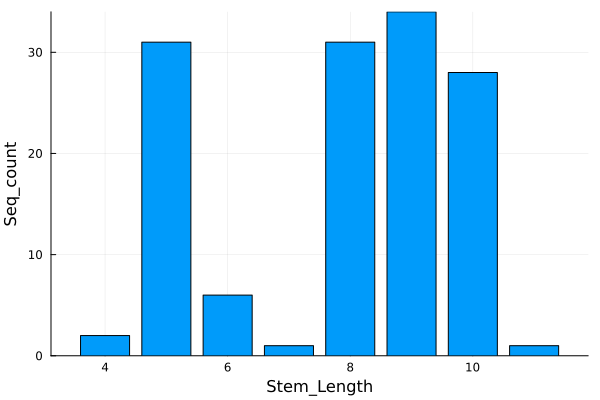

In [34]:
# Create bar plot indicating the amount of different seq per structure

plot(bar(Stem_ranges), 
    legend = false,
    xlabel = "Stem_Length",
    ylabel = "Seq_count")


In [35]:
ShortestStem = "1-4-1-5-5-5-1-4-1"
ShortestStemAnalysis = filter(:Loop1_description => n -> n == ShortestStem, ForStemAnalysis)
sort!(ShortestStemAnalysis, [:MFE_energy, :Mbp_dist])

Row,Sequence_number,Loop1_description,MFE_SUBstructure,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Int64,String,String,String,Int64,Int64,String7,String,Float64,Float64,Int64,Int64
1,35704,1-4-1-5-5-5-1-4-1,.((((.(((((.....))))).)))).,ACAAAAAAACCTAAATGGTTTGTTTGCC,28,1,false,.((((.(((((.....))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-28.6,4.91397,0,0
2,42587,1-4-1-5-5-5-1-4-1,.((((.(((((.....))))).)))).,ACAAAAAAACCTCTCTGGTTTGTTTGCC,28,1,false,.((((.(((((.....))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-28.6,4.91399,0,0
3,20206,1-4-1-5-5-5-1-4-1,.((((.(((((.....))))).)))).,ACAAAAAAACCTCAATGGTTTGTTTGCC,28,1,false,.((((.(((((.....))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-28.6,4.91576,0,0
4,25739,1-4-1-5-5-5-1-4-1,.((((.(((((.....))))).)))).,ACAAAAAAACCTCATTGGTTTGTTTGCC,28,1,false,.((((.(((((.....))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-28.6,4.92089,0,0
5,16154,1-4-1-5-5-5-1-4-1,.((((.(((((.....))))).)))).,ACAAAAAAACCTGTGTGGTTTGTTTGCC,28,1,false,.((((.(((((.....))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-28.6,4.93272,0,0
6,6280,1-4-1-5-5-5-1-4-1,.((((.(((((.....))))).)))).,ACAAAAAAACCGTTATGGTTTGTTTGCC,28,2,false,.((((.(((((.....))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-28.0,4.96187,0,0
7,4032,1-4-1-5-5-5-1-4-1,.((((.(((((.....))))).)))).,ACAAAAAAACCGACCTGGTTTGTTTGCC,28,2,false,.((((.(((((.....))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-28.0,4.96292,0,0
8,42419,1-4-1-5-5-5-1-4-1,.((((.(((((.....))))).)))).,ACAAAAAAACCGGAATGGTTTGTTTGCC,28,1,false,.((((.(((((.....))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-28.0,4.97357,0,0
9,44499,1-4-1-5-5-5-1-4-1,.((((.(((((.....))))).)))).,ACAAAAAAACCACTCTGGTTTGTTTGCC,28,1,false,.((((.(((((.....))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-28.0,5.17798,0,0


In [36]:
Pattern4Structures = DataFrame(Stem_length=[], Loop_length=[], Count_different_seq=[], max_MFE_energy=[], min_MFE_energy=[])
for i = 3:50
    loop_length = i
    search_set_stem = []
    for n = 1: 20
        wt_pre = "1-4-1-"
        wt_loop = "-$(loop_length)-"
        wt_pos = "-1-4-1"

        new_item = wt_pre * "$(n)" * wt_loop * "$(n)" * wt_pos
        push!(search_set_stem, new_item)
    end
    search_set_stem

    ForStemAnalysis = filter(:Loop1_description => n -> n ∈ search_set_stem, lib_StructureAnalysis)
    sort!(ForStemAnalysis, [:MFE_energy, :Mbp_dist])

    ## sorting the structures with relative similarity by their actual Loop1_description
    StemSame_structure = []
    for structure in ForStemAnalysis.MFE_SUBstructure
        if structure ∉ StemSame_structure && structure != WT_structure
            push!(StemSame_structure, structure)
        end
    end
    StemSame_structure

    
    count = 0
    for structure in StemSame_structure
        count += 1
        #tuple_struct = ("Stem_length" = , "Loop_length" = , "Count_different_seq" = , "max_MFE_energy" = , "min_MFE_energy" = )
        #loop_length = 4

        structureFrame = filter(:MFE_SUBstructure => n -> n == structure, lib_StructureAnalysis)
        sort!(structureFrame, [:MFE_energy, :Mbp_dist])
        Loop_description = structureFrame.Loop1_description[1]

        stem_length = find_x_values(Loop_description)[1]
        amount_seq = size(structureFrame)[1]
        max_energy = structureFrame.MFE_energy[amount_seq]
        min_energy = structureFrame.MFE_energy[1]

        tuple_struct = (Stem_length = stem_length, Loop_length = loop_length, Count_different_seq = amount_seq, max_MFE_energy = max_energy, min_MFE_energy = min_energy)
        #tuple_struct = ("Stem_length" = stem_length, "Loop_length" = loop_length, "Count_different_seq" = amount_seq, "max_MFE_energy" = max_energy, "min_MFE_energy" = min_energy)
        #push!(tuple_struct, (stem_length, loop_length, amount_seq, max_energy, min_energy))
        push!(Pattern4Structures, tuple_struct)
    end
end

sort!(Pattern4Structures, [:Loop_length, :Stem_length])

Row,Stem_length,Loop_length,Count_different_seq,max_MFE_energy,min_MFE_energy
,Any,Any,Any,Any,Any
1,5,3,13,-25.6,-25.6
2,8,3,5,-33.2,-33.2
3,9,3,3,-34.1,-34.4
4,10,3,3,-35.1,-35.4
5,11,3,2,-34.1,-36.2
6,5,4,25,-25.3,-28.6
7,6,4,6,-26.2,-29.8
8,7,4,1,-29.5,-29.5
9,8,4,21,-30.6,-36.2


### Different length Loop - Analysis

<a id='searchset_loop'></a>

In [37]:
search_set_loop = []
for n = 1: 20
    wt_pre = "1-4-1-10-"
    #wt_loop = "-5-"
    wt_pos = "-10-1-4-1"
    
    new_item = wt_pre * "$(n)" * wt_pos
    push!(search_set_loop, new_item)
end
search_set_loop

20-element Vector{Any}:
 "1-4-1-10-1-10-1-4-1"
 "1-4-1-10-2-10-1-4-1"
 "1-4-1-10-3-10-1-4-1"
 "1-4-1-10-4-10-1-4-1"
 "1-4-1-10-5-10-1-4-1"
 "1-4-1-10-6-10-1-4-1"
 "1-4-1-10-7-10-1-4-1"
 "1-4-1-10-8-10-1-4-1"
 "1-4-1-10-9-10-1-4-1"
 "1-4-1-10-10-10-1-4-1"
 "1-4-1-10-11-10-1-4-1"
 "1-4-1-10-12-10-1-4-1"
 "1-4-1-10-13-10-1-4-1"
 "1-4-1-10-14-10-1-4-1"
 "1-4-1-10-15-10-1-4-1"
 "1-4-1-10-16-10-1-4-1"
 "1-4-1-10-17-10-1-4-1"
 "1-4-1-10-18-10-1-4-1"
 "1-4-1-10-19-10-1-4-1"
 "1-4-1-10-20-10-1-4-1"

In [38]:
ForLoopAnalysis = filter(:Loop1_description => n -> n ∈ search_set_loop, lib_StructureAnalysis)
sort!(ForLoopAnalysis, [:MFE_energy, :Mbp_dist])

Row,Sequence_number,Loop1_description,MFE_SUBstructure,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Int64,String,String,String,Int64,Int64,String7,String,Float64,Float64,Int64,Int64
1,32146,1-4-1-10-6-10-1-4-1,.((((.((((((((((......)))))))))).)))).,ACAAAAAAACCAGCGGCACTAACCGCTGGTTTGTTTGCC,39,1,false,.((((.((((((((((......)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-41.1,4.92077,0,0
2,7520,1-4-1-10-6-10-1-4-1,.((((.((((((((((......)))))))))).)))).,ACAAAAAAACCAGCCGAAGGTACGGCTGGTTTGTTTGCC,39,2,false,.((((.((((((((((......)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-41.1,4.97542,0,0
3,0,1-4-1-10-5-10-1-4-1,.((((.((((((((((.....)))))))))).)))).,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCC,38,47,WT,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-41.1,5.30195,0,0
4,23411,1-4-1-10-6-10-1-4-1,.((((.((((((((((......)))))))))).)))).,ACAAAAAAACCACTCCGCCTTAGGAGTGGTTTGTTTGCC,39,1,false,.((((.((((((((((......)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-40.9,4.90256,0,0
5,15824,1-4-1-10-6-10-1-4-1,.((((.((((((((((......)))))))))).)))).,ACAAAAAAACCAGGCATACTGTTGCCTGGTTTGTTTGCC,39,1,false,.((((.((((((((((......)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-40.9,5.00045,0,0
6,9816,1-4-1-10-6-10-1-4-1,.((((.((((((((((......)))))))))).)))).,ACAAAAAAACCACCGGTTTCTCCCGGTGGTTTGTTTGCC,39,1,false,.((((.((((((((((......)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-40.8,4.95773,0,0
7,14114,1-4-1-10-6-10-1-4-1,.((((.((((((((((......)))))))))).)))).,ACAAAAAAACCACCCATACTGTTGGGTGGTTTGTTTGCC,39,1,false,.((((.((((((((((......)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-40.7,5.00055,0,0
8,4840,1-4-1-10-6-10-1-4-1,.((((.((((((((((......)))))))))).)))).,ACAAAAAAACCAGCCTTAGAGTGGGCTGGTTTGTTTGCC,39,2,false,.((((.((((((((((......)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-40.6,4.93715,0,0
9,31076,1-4-1-10-6-10-1-4-1,.((((.((((((((((......)))))))))).)))).,ACAAAAAAACCACACCTTGAGTGGTGTGGTTTGTTTGCC,39,1,false,.((((.((((((((((......)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-40.5,4.90344,0,0


In [39]:
## sorting the structures with relative similarity by their actual Loop1_description
LoopSame_structure = []
for structure in ForLoopAnalysis.MFE_SUBstructure
    if structure ∉ LoopSame_structure
        push!(LoopSame_structure, structure)
    end
end
LoopSame_structure

5-element Vector{Any}:
 ".((((.((((((((((......)))))))))).))))."
 ".((((.((((((((((.....)))))))))).))))."
 ".((((.((((((((((....)))))))))).))))."
 ".((((.((((((((((.......)))))))))).))))."
 ".((((.((((((((((...)))))))))).))))."

In [40]:
## getting an overview on the loop sizes of the hairpin structures
y_range = find_y_range(ForLoopAnalysis.Loop1_description)

println("Range of Loop bases:")
println(sort!(collect(y_range)))

LoadError: MethodError: no method matching find_y_range(::Vector{String})

[0mClosest candidates are:
[0m  find_y_range([91m::Vector{String31}[39m)
[0m[90m   @[39m [36mMain[39m [90m[4mIn[13]:2[24m[39m


In [41]:
Loop_ranges = Dict{Int64,Int64}()
for num in sort!(collect(y_range))
    Loop1_desc = "1-4-1-10-$(num)-10-1-4-1"
    seq_dataframe = filter(:Loop1_description => n -> n == Loop1_desc, lib_StructureAnalysis)
    count_seq = nrow(seq_dataframe)
    Loop_ranges[num] = count_seq
end
Loop_ranges

LoadError: UndefVarError: `y_range` not defined

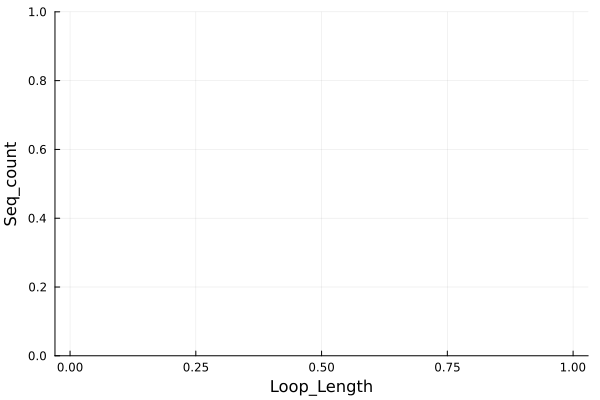

In [42]:
# Create bar plot indicating the amount of different seq per structure
#plot(Stem_ranges, x=keys(my_dict), seriestype=:histogram)
plot(bar(Loop_ranges), 
    legend = false,
    xlabel = "Loop_Length",
    ylabel = "Seq_count",)

In [43]:
LongestLoop = "1-4-1-10-6-10-1-4-1"
LongestLoopAnalysis = filter(:Loop1_description => n -> n == LongestLoop, ForLoopAnalysis)
sort!(LongestLoopAnalysis, [:MFE_energy, :Mbp_dist])

Row,Sequence_number,Loop1_description,MFE_SUBstructure,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Int64,String,String,String,Int64,Int64,String7,String,Float64,Float64,Int64,Int64
1,32146,1-4-1-10-6-10-1-4-1,.((((.((((((((((......)))))))))).)))).,ACAAAAAAACCAGCGGCACTAACCGCTGGTTTGTTTGCC,39,1,false,.((((.((((((((((......)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-41.1,4.92077,0,0
2,7520,1-4-1-10-6-10-1-4-1,.((((.((((((((((......)))))))))).)))).,ACAAAAAAACCAGCCGAAGGTACGGCTGGTTTGTTTGCC,39,2,false,.((((.((((((((((......)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-41.1,4.97542,0,0
3,23411,1-4-1-10-6-10-1-4-1,.((((.((((((((((......)))))))))).)))).,ACAAAAAAACCACTCCGCCTTAGGAGTGGTTTGTTTGCC,39,1,false,.((((.((((((((((......)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-40.9,4.90256,0,0
4,15824,1-4-1-10-6-10-1-4-1,.((((.((((((((((......)))))))))).)))).,ACAAAAAAACCAGGCATACTGTTGCCTGGTTTGTTTGCC,39,1,false,.((((.((((((((((......)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-40.9,5.00045,0,0
5,9816,1-4-1-10-6-10-1-4-1,.((((.((((((((((......)))))))))).)))).,ACAAAAAAACCACCGGTTTCTCCCGGTGGTTTGTTTGCC,39,1,false,.((((.((((((((((......)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-40.8,4.95773,0,0
6,14114,1-4-1-10-6-10-1-4-1,.((((.((((((((((......)))))))))).)))).,ACAAAAAAACCACCCATACTGTTGGGTGGTTTGTTTGCC,39,1,false,.((((.((((((((((......)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-40.7,5.00055,0,0
7,4840,1-4-1-10-6-10-1-4-1,.((((.((((((((((......)))))))))).)))).,ACAAAAAAACCAGCCTTAGAGTGGGCTGGTTTGTTTGCC,39,2,false,.((((.((((((((((......)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-40.6,4.93715,0,0
8,31076,1-4-1-10-6-10-1-4-1,.((((.((((((((((......)))))))))).)))).,ACAAAAAAACCACACCTTGAGTGGTGTGGTTTGTTTGCC,39,1,false,.((((.((((((((((......)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-40.5,4.90344,0,0
9,21928,1-4-1-10-6-10-1-4-1,.((((.((((((((((......)))))))))).)))).,ACAAAAAAACCACCCTTGCTTTGGGGTGGTTTGTTTGCC,39,1,false,.((((.((((((((((......)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-40.4,4.94102,0,0


In [44]:
ShortestLoop = "1-4-1-10-3-10-1-4-1"
ShortestLoopAnalysis = filter(:Loop1_description => n -> n == ShortestLoop, ForLoopAnalysis)
sort!(ShortestLoopAnalysis, [:MFE_energy, :Mbp_dist])

Row,Sequence_number,Loop1_description,MFE_SUBstructure,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Int64,String,String,String,Int64,Int64,String7,String,Float64,Float64,Int64,Int64
1,38404,1-4-1-10-3-10-1-4-1,.((((.((((((((((...)))))))))).)))).,ACAAAAAAACCAGTAGCACCTACTGGTTTGTTTGCC,36,1,false,.((((.((((((((((...)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-35.4,5.34033,0,0
2,16293,1-4-1-10-3-10-1-4-1,.((((.((((((((((...)))))))))).)))).,ACAAAAAAACCAAGTCTCTGACTTGGTTTGTTTGCC,36,1,false,.((((.((((((((((...)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-35.3,5.19074,0,0
3,43856,1-4-1-10-3-10-1-4-1,.((((.((((((((((...)))))))))).)))).,ACAAAAAAACCAACACTGAGTGTTGGTTTGTTTGCC,36,1,false,.((((.((((((((((...)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-35.1,5.31461,0,0


In [46]:
## listing the seq_numbers with the same structure in a dictionary

dict_LoopSame_structure = Dict()

for substructure in LoopSame_structure
    seqNO_substruc = []
    entries_substruc = filter(:MFE_SUBstructure => n -> n == substructure, libStructureAnalysis)
    for entry in entries_substruc.Sequence_number
        push!(seqNO_substruc, entry)
    end
    
    dict_LoopSame_structure[substructure] = seqNO_substruc
end

## print the seq_numbers to every substructure
#for entry in dict_LoopSame_structure
 #   println(entry)
  #  pritnln("------------------------")
#end

## print the amount of seq per substructure
for value in values(dict_LoopSame_structure)
    println(size(value))
    println(keys(dict_LoopSame_structure))
end

(866,)
Any[".((((.((((((((((......)))))))))).)))).", ".((((.((((((((((.......)))))))))).)))).", ".((((.((((((((((...)))))))))).)))).", ".((((.((((((((((....)))))))))).)))).", ".((((.((((((((((.....)))))))))).))))."]
(3,)
Any[".((((.((((((((((......)))))))))).)))).", ".((((.((((((((((.......)))))))))).)))).", ".((((.((((((((((...)))))))))).)))).", ".((((.((((((((((....)))))))))).)))).", ".((((.((((((((((.....)))))))))).))))."]
(3,)
Any[".((((.((((((((((......)))))))))).)))).", ".((((.((((((((((.......)))))))))).)))).", ".((((.((((((((((...)))))))))).)))).", ".((((.((((((((((....)))))))))).)))).", ".((((.((((((((((.....)))))))))).))))."]
(8,)
Any[".((((.((((((((((......)))))))))).)))).", ".((((.((((((((((.......)))))))))).)))).", ".((((.((((((((((...)))))))))).)))).", ".((((.((((((((((....)))))))))).)))).", ".((((.((((((((((.....)))))))))).))))."]
(28,)
Any[".((((.((((((((((......)))))))))).)))).", ".((((.((((((((((.......)))))))))).)))).", ".((((.((((((((((...)))))))))).)))).", ".((((.(

#### Searching for Sequences with variable upper stem & Loop (1-4-1-x-y-x-1-4-1)

<a id='L1M2varStem_Loop'></a>

In [47]:
## creating search set to filter sequences based on variable upper stem and loop
## the ranges were determined by the maximum LoopI length of the L1L1 (== 47 bases) and the bases for the lower stem were substracted (minus 12 bases)
## for the stem was considered that it has to be symmetric -> maximum of m is (half of LoopI length - 12 bases)

search_set_uStemLoop = []
for n = 1: 20
    for m = 1:35
        wt_pre = "1-4-1-"
        wt_loop = "-5-"
        wt_pos = "-1-4-1"

        new_item = wt_pre * "$(n)" * "-" * "$(m)" * "-" * "$(n)" * wt_pos
        push!(search_set_uStemLoop, new_item)
    end   
end
search_set_uStemLoop

700-element Vector{Any}:
 "1-4-1-1-1-1-1-4-1"
 "1-4-1-1-2-1-1-4-1"
 "1-4-1-1-3-1-1-4-1"
 "1-4-1-1-4-1-1-4-1"
 "1-4-1-1-5-1-1-4-1"
 "1-4-1-1-6-1-1-4-1"
 "1-4-1-1-7-1-1-4-1"
 "1-4-1-1-8-1-1-4-1"
 "1-4-1-1-9-1-1-4-1"
 "1-4-1-1-10-1-1-4-1"
 "1-4-1-1-11-1-1-4-1"
 "1-4-1-1-12-1-1-4-1"
 "1-4-1-1-13-1-1-4-1"
 ⋮
 "1-4-1-20-24-20-1-4-1"
 "1-4-1-20-25-20-1-4-1"
 "1-4-1-20-26-20-1-4-1"
 "1-4-1-20-27-20-1-4-1"
 "1-4-1-20-28-20-1-4-1"
 "1-4-1-20-29-20-1-4-1"
 "1-4-1-20-30-20-1-4-1"
 "1-4-1-20-31-20-1-4-1"
 "1-4-1-20-32-20-1-4-1"
 "1-4-1-20-33-20-1-4-1"
 "1-4-1-20-34-20-1-4-1"
 "1-4-1-20-35-20-1-4-1"

In [48]:
ForuStemLoopAnalysis = filter(:Loop1_description => n -> n ∈ search_set_uStemLoop, libStructureAnalysis)

LoadError: UndefVarError: `libStructureAnalysis` not defined

In [49]:
## sorting the structures with relative similarity by their actual Loop1_description
uStemLoopSame_structure = []
for structure in ForuStemLoopAnalysis.MFE_SUBstructure
    if structure ∉ uStemLoopSame_structure
        push!(uStemLoopSame_structure, structure)
    end
end
uStemLoopSame_structure

LoadError: UndefVarError: `ForuStemLoopAnalysis` not defined

In [50]:
lib_uStemLoopAnalysis = filter(:MFE_SUBstructure => n -> n ∈ uStemLoopSame_structure, libStructureAnalysis)

LoadError: UndefVarError: `libStructureAnalysis` not defined

In [63]:
## listing the seq_numbers with the same structure in a dictionary

dict_uStemLoopSame_structure = Dict()

for substructure in uStemLoopSame_structure
    seqNO_substruc = []
    entries_substruc = filter(:MFE_SUBstructure => n -> n == substructure, libStructureAnalysis)
    for entry in entries_substruc.Sequence_number
        push!(seqNO_substruc, entry)
    end
    
    dict_uStemLoopSame_structure[substructure] = seqNO_substruc
end

## print the seq_numbers to every substructure
#for entry in dict_uStemLoopSame_structure
    #println(entry)
    #pritnln("------------------------")
#end

## print the amount of seq per substructure
sum = 0
for value in values(dict_uStemLoopSame_structure)
    println(size(value)[1])
    sum += size(value)[1]
    #println(keys(dict_uStemLoopSame_structure))
end
sum

2
44
2036
1924
50
28
1563
1226
47
426
15012
3
8
866
364
72


23671

#### Convenient point for saving partial results and for restarting later analysis

In [65]:
save_name = "varLoopStemAnalysis_" * file_name[1:end-6] * ".csv"


## Saving results
CSV.write(save_name, lib_uStemLoopAnalysis)

## Opening saved results
lib_uStemLoopAnalysis = CSV.read(save_name, DataFrame);

In [66]:
function find_y_range(strings::Vector{String})
    y_values = Set{Int}()

    for str in strings
        # Extract the y value from the string
        match_result = match(r"1-4-1-\d+-(\d+)-\d+-1-4-1", str)
        
        if match_result !== nothing
            y_value = parse(Int, match_result.captures[1])
            push!(y_values, y_value)
        end
    end

    return y_values
end


find_y_range (generic function with 1 method)

In [68]:
## getting an overview on the loop sizes of the hairpin structures
y_range = find_y_range(libStructureAnalysis.Loop1_description)

println("Range of y values:")
println(sort!(collect(y_range)))

Range of y values:
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


In [72]:
L1M2short4Loop = ".((((.(((((((((((....))))))))))).))))."
lib_L1M2short4Loop = filter(:MFE_SUBstructure => n -> n == L1M2short4Loop, libStructureAnalysis)

Row,Sequence_number,Loop1_description,MFE_SUBstructure,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Int64,String,String,String,Int64,Int64,String7,String,Float64,Float64,Int64,Int64
1,18,1-4-1-11-4-11-1-4-1,.((((.(((((((((((....))))))))))).)))).,ACAAAAAAACCACTTCCAATCGGAGGTGGTTTGTTTGCC,39,16,false,.((((.(((((((((((....))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-39.0,4.92684,0,0
2,287,1-4-1-11-4-11-1-4-1,.((((.(((((((((((....))))))))))).)))).,ACAAAAAAACCACGTTTTCGCAGACGTGGTTTGTTTGCC,39,5,false,.((((.(((((((((((....))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-37.3,5.50734,0,0
3,357,1-4-1-11-4-11-1-4-1,.((((.(((((((((((....))))))))))).)))).,ACAAAAAAACCAGTAATATCCATTACTGGTTTGTTTGCC,39,5,false,.((((.(((((((((((....))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-36.1,5.46033,0,0
4,380,1-4-1-11-4-11-1-4-1,.((((.(((((((((((....))))))))))).)))).,ACAAAAAAACCACTCTTACCTAGGAGTGGTTTGTTTGCC,39,5,false,.((((.(((((((((((....))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-38.2,5.34986,0,0
5,781,1-4-1-11-4-11-1-4-1,.((((.(((((((((((....))))))))))).)))).,ACAAAAAAACCAGCTGTATATATAGCTGGTTTGTTTGCC,39,4,false,.((((.(((((((((((....))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-37.2,5.79305,0,0
6,794,1-4-1-11-4-11-1-4-1,.((((.(((((((((((....))))))))))).)))).,ACAAAAAAACCAAATTGCTCCCAATTTGGTTTGTTTGCC,39,4,false,.((((.(((((((((((....))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-35.2,4.96752,0,0
7,926,1-4-1-11-4-11-1-4-1,.((((.(((((((((((....))))))))))).)))).,ACAAAAAAACCACTATTGTTAAGTAGTGGTTTGTTTGCC,39,4,false,.((((.(((((((((((....))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-36.2,5.33948,0,0
8,1012,1-4-1-11-4-11-1-4-1,.((((.(((((((((((....))))))))))).)))).,ACAAAAAAACCACTAAGCTTATTTAGTGGTTTGTTTGCC,39,4,false,.((((.(((((((((((....))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-35.7,5.63256,0,0
9,1213,1-4-1-11-4-11-1-4-1,.((((.(((((((((((....))))))))))).)))).,ACAAAAAAACCACTGATGATAATCAGTGGTTTGTTTGCC,39,3,false,.((((.(((((((((((....))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-40.0,4.94916,0,0


In [70]:
L1M2medium7Loop = ".((((.(((((((((.......))))))))).))))."
lib_L1M2medium7Loop = filter(:MFE_SUBstructure => n -> n == L1M2medium7Loop, libStructureAnalysis)

Row,Sequence_number,Loop1_description,MFE_SUBstructure,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Int64,String,String,String,Int64,Int64,String7,String,Float64,Float64,Int64,Int64
1,882,1-4-1-9-7-9-1-4-1,.((((.(((((((((.......))))))))).)))).,ACAAAAAAACCAGACGATCTAGGTCTGGTTTGTTTGCC,38,4,false,.((((.(((((((((.......))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-35.7,5.06427,0,0
2,2180,1-4-1-9-7-9-1-4-1,.((((.(((((((((.......))))))))).)))).,ACAAAAAAACCCATTCGCTACAGATGGGTTTGTTTGCC,38,3,false,.((((.(((((((((.......))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-34.5,6.22241,0,0
3,2909,1-4-1-9-7-9-1-4-1,.((((.(((((((((.......))))))))).)))).,ACAAAAAAACCACCTATTATAGAGGTGGTTTGTTTGCC,38,2,false,.((((.(((((((((.......))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-36.6,5.07086,0,0
4,3228,1-4-1-9-7-9-1-4-1,.((((.(((((((((.......))))))))).)))).,ACAAAAAAACCAAGGCTTTCATCCTTGGTTTGTTTGCC,38,2,false,.((((.(((((((((.......))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-35.4,4.95235,0,0
5,3794,1-4-1-9-7-9-1-4-1,.((((.(((((((((.......))))))))).)))).,ACAAAAAAACCAGGGGCGTGCTCCCTGGTTTGTTTGCC,38,2,false,.((((.(((((((((.......))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-38.8,5.30118,0,0
6,5046,1-4-1-9-7-9-1-4-1,.((((.(((((((((.......))))))))).)))).,ACAAAAAAACCAAGGATCTTAACCTTGGTTTGTTTGCC,38,2,false,.((((.(((((((((.......))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-36.0,4.93994,0,0
7,5674,1-4-1-9-7-9-1-4-1,.((((.(((((((((.......))))))))).)))).,ACAAAAAAACCAGGCTTGGGATGCCTGGTTTGTTTGCC,38,2,false,.((((.(((((((((.......))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-39.7,4.90684,0,0
8,9001,1-4-1-9-7-9-1-4-1,.((((.(((((((((.......))))))))).)))).,ACAAAAAAACCACCTAGAGCTAAGGTGGTTTGTTTGCC,38,1,false,.((((.(((((((((.......))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-36.7,5.09842,0,0
9,15928,1-4-1-9-7-9-1-4-1,.((((.(((((((((.......))))))))).)))).,ACAAAAAAACCACAACTAGACATTGTGGTTTGTTTGCC,38,1,false,.((((.(((((((((.......))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-33.9,5.4553,0,0


In [69]:
L1M2long10Loop = ".((((.((((((((..........)))))))).))))."
lib_L1M2long10Loop = filter(:MFE_SUBstructure => n -> n == L1M2long10Loop, libStructureAnalysis)

Row,Sequence_number,Loop1_description,MFE_SUBstructure,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Int64,String,String,String,Int64,Int64,String7,String,Float64,Float64,Int64,Int64
1,30,1-4-1-8-10-8-1-4-1,.((((.((((((((..........)))))))).)))).,ACAAAAAAACCAGTGCTTTCTCAGACTGGTTTGTTTGCC,39,11,false,.((((.((((((((..........)))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-33.3,6.05727,0,0
2,33,1-4-1-8-10-8-1-4-1,.((((.((((((((..........)))))))).)))).,ACAAAAAAACCACGACTTCTGCTCCGTGGTTTGTTTGCC,39,10,false,.((((.((((((((..........)))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-33.1,6.05773,0,0
3,38,1-4-1-8-10-8-1-4-1,.((((.((((((((..........)))))))).)))).,ACAAAAAAACCACGCATTTACGAACGTGGTTTGTTTGCC,39,10,false,.((((.((((((((..........)))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-34.3,5.00239,0,0
4,51,1-4-1-8-10-8-1-4-1,.((((.((((((((..........)))))))).)))).,ACAAAAAAACCAGTCTACTTTGAAACTGGTTTGTTTGCC,39,9,false,.((((.((((((((..........)))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-33.1,5.4746,0,0
5,54,1-4-1-8-10-8-1-4-1,.((((.((((((((..........)))))))).)))).,ACAAAAAAACCACGTTCCTCTGGCCGTGGTTTGTTTGCC,39,9,false,.((((.((((((((..........)))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-34.2,6.00131,0,0
6,55,1-4-1-8-10-8-1-4-1,.((((.((((((((..........)))))))).)))).,ACAAAAAAACCACCGTCGACAAAAGGTGGTTTGTTTGCC,39,9,false,.((((.((((((((..........)))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-36.4,4.91108,0,0
7,61,1-4-1-8-10-8-1-4-1,.((((.((((((((..........)))))))).)))).,ACAAAAAAACCACCTTTATTTGTCGGTGGTTTGTTTGCC,39,9,false,.((((.((((((((..........)))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-35.5,4.91468,0,0
8,79,1-4-1-8-10-8-1-4-1,.((((.((((((((..........)))))))).)))).,ACAAAAAAACCAAGCCACAGTCCACTTGGTTTGTTTGCC,39,8,false,.((((.((((((((..........)))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-32.7,6.27544,0,0
9,81,1-4-1-8-10-8-1-4-1,.((((.((((((((..........)))))))).)))).,ACAAAAAAACCACCATTTTCACAAGGTGGTTTGTTTGCC,39,8,false,.((((.((((((((..........)))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-35.6,4.98329,0,0


### Analysis of Seq with similar relative Structure as WT

Here I filtered for Sequences that look very similar to the WT-structure. So they have the same relative lengths as the WT. I found a few possible sequences which can be looked at in more detail at another point. There I can also look into the base variation of the sequences with the same structure, the MFE_energy, Mbp_dist, Counts of the sequences and whatever I come up with :)

* [including the relative lengths of the structures in the dataframe](#relative_WTStructure)
* [filtering seq with the same relative structure as WT](#relative_filterSimilar)
* [mapping the diversity of the structures + assigning the seq_number to the structure accordingly](#relative_structAssign)

<a id='relative_WTStructure'></a>

In [51]:
## comparing relative lengths of the WT-hairpin structure

## creating the relative LoopI structure-description of every sequence and including it into a dataframe
rel_description = DataFrame([[],[]],["Sequence_number", "Rel_Loop1_description"])

for n = 1: size(libStructureAnalysis, 1)
    sub_struc = libStructureAnalysis.MFE_SUBstructure[n]
    seq_num = libStructureAnalysis.Sequence_number[n]

    range_structure = vcat(loop_ranges(sub_struc, 1, '('), loop_ranges(sub_struc, 1, ')'), loop_ranges(sub_struc, 1, '.'))
    sort!(range_structure)
    
    structure_sum = ""
    for i in range_structure
    rel_structure_sum = (length(i)) / length(sub_struc)
    rel_structure_sum = round(rel_structure_sum, digits=1)
        if structure_sum == ""
            structure_sum = (structure_sum * "$rel_structure_sum")
        else
            structure_sum = structure_sum * "-" * "$rel_structure_sum"
        end
    end
    push!(rel_description, (seq_num, structure_sum))

end

libStructureAnalysisClean = innerjoin(rel_description, libStructureAnalysis, on = :Sequence_number)
        

LoadError: UndefVarError: `libStructureAnalysis` not defined

#### Convenient point for saving partial results and for restarting later analysis

In [15]:
save_name = "RelativeWTAnalysis_" * file_name[1:end-6] * ".csv"


## Saving results
CSV.write(save_name, libStructureAnalysisClean)

## Opening saved results
#save_name = "StructureAnalysisReady_Old_large_Loop1_rc.csv"
libStructureAnalysisClean = CSV.read(save_name, DataFrame);


<a id='relative_filterSimilar'></a>

In [16]:
## filter the sequences with the same Rel_Loop1_description as the WT sequence

search_rel_WT = libStructureAnalysisClean[42147, :Rel_Loop1_description]
ForRelAnalysis = filter(:Rel_Loop1_description => n -> n == search_rel_WT, libStructureAnalysisClean)
sort!(ForRelAnalysis, :MFE_energy)

Row,Sequence_number,Rel_Loop1_description,Loop1_description,MFE_SUBstructure,LoopI,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Seq_Cluster,Str_Cluster
,Int64,String,String,String,String,Int64,Int64,String7,String,Float64,Float64,Int64,Int64
1,43398,0.0-0.1-0.0-0.3-0.1-0.3-0.0-0.1-0.0,1-4-1-11-4-11-1-4-1,.((((.(((((((((((....))))))))))).)))).,ACAAAAAAACCGGCCCTGTGAGGGGCTGGTTTGTTTGCC,39,1,false,.((((.(((((((((((....))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-42.3,4.93401,0,0
2,18049,0.0-0.1-0.0-0.3-0.1-0.3-0.0-0.1-0.0,1-4-1-11-4-11-1-4-1,.((((.(((((((((((....))))))))))).)))).,ACAAAAAAACCAGACTCTTCTGAGTCTGGTTTGTTTGCC,39,1,false,.((((.(((((((((((....))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-41.9,4.90523,0,0
3,35544,0.0-0.1-0.0-0.3-0.1-0.3-0.0-0.1-0.0,1-4-1-11-4-11-1-4-1,.((((.(((((((((((....))))))))))).)))).,ACAAAAAAACCGCCGCTTGTTAGCGGTGGTTTGTTTGCC,39,1,false,.((((.(((((((((((....))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-41.8,4.97509,0,0
4,41799,0.0-0.1-0.0-0.3-0.1-0.3-0.0-0.1-0.0,1-4-1-11-4-11-1-4-1,.((((.(((((((((((....))))))))))).)))).,ACAAAAAAACCATCTGCTTGCGCAGATGGTTTGTTTGCC,39,1,false,.((((.(((((((((((....))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-41.3,4.90407,0,0
5,12569,0.0-0.1-0.0-0.3-0.1-0.3-0.0-0.1-0.0,1-4-1-11-4-11-1-4-1,.((((.(((((((((((....))))))))))).)))).,ACAAAAAAACCAGTGGAGAGTTCCACTGGTTTGTTTGCC,39,1,false,.((((.(((((((((((....))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-41.2,5.07345,0,0
6,38434,0.0-0.1-0.0-0.3-0.1-0.3-0.0-0.1-0.0,1-4-1-11-4-11-1-4-1,.((((.(((((((((((....))))))))))).)))).,ACAAAAAAACCACCCTAGCAATGGGGTGGTTTGTTTGCC,39,1,false,.((((.(((((((((((....))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-41.2,5.08755,0,0
7,0,0.0-0.1-0.0-0.3-0.1-0.3-0.0-0.1-0.0,1-4-1-10-5-10-1-4-1,.((((.((((((((((.....)))))))))).)))).,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCC,38,47,WT,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-41.1,5.30195,0,0
8,13981,0.0-0.1-0.0-0.3-0.1-0.3-0.0-0.1-0.0,1-4-1-11-4-11-1-4-1,.((((.(((((((((((....))))))))))).)))).,ACAAAAAAACCACCTGGTCACCCGGGTGGTTTGTTTGCC,39,1,false,.((((.(((((((((((....))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-41.0,4.92888,0,0
9,30402,0.0-0.1-0.0-0.3-0.1-0.3-0.0-0.1-0.0,1-4-1-11-4-11-1-4-1,.((((.(((((((((((....))))))))))).)))).,ACAAAAAAACCACACAGTCATCTGTGTGGTTTGTTTGCC,39,1,false,.((((.(((((((((((....))))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-40.9,4.91736,0,0


<a id='relative_structAssign'></a>

In [25]:
## sorting the structures with relative similarity by their actual Loop1_description
relSame_structure = []
for structure in ForRelAnalysis.MFE_SUBstructure
    if structure ∉ relSame_structure
        push!(relSame_structure, structure)
    end
end
relSame_structure

3-element Vector{Any}:
 ".((((.(((((((((((....))))))))))).))))."
 ".((((.((((((((((.....)))))))))).))))."
 ".((((.(((((((((((...))))))))))).))))."

In [18]:
## listing the seq_numbers with the same structure in a dictionary

#substructure = ".((((.((((((((((((((......)))))))))))))).))))."
dict_relSame_structure = Dict()

for substructure in relSame_structure
    seqNO_substruc = []
    entries_substruc = filter(:MFE_SUBstructure => n -> n == substructure, libStructureAnalysisClean)
    for entry in entries_substruc.Sequence_number
        push!(seqNO_substruc, entry)
    end
    
    dict_relSame_structure[substructure] = seqNO_substruc
end
#seqNO_substruc
for entry in dict_relSame_structure
    println(entry)
    println("------------------------")
end

Pair{Any, Any}(".((((.(((((((((((....))))))))))).)))).", Any[18, 287, 357, 380, 781, 794, 926, 1012, 1213, 1263, 1333, 1484, 1614, 1671, 1674, 1721, 1736, 1915, 2136, 2427, 2591, 2906, 3120, 3137, 3269, 3519, 3653, 3663, 3726, 3762, 4007, 4194, 4280, 4304, 4390, 4439, 4708, 4796, 4873, 4991, 5082, 5145, 5157, 5251, 5316, 5331, 5338, 5350, 5565, 5571, 5611, 5667, 5716, 5807, 6004, 6019, 6189, 6398, 6420, 6532, 6579, 6751, 6834, 6861, 7185, 7465, 7506, 7555, 7740, 7896, 8018, 8272, 8278, 8288, 8403, 8455, 8677, 8773, 8796, 8899, 9139, 9166, 9278, 9458, 9467, 9680, 9688, 9811, 9842, 9863, 9995, 9998, 10061, 10074, 10101, 10352, 10681, 10728, 10889, 11075, 11177, 11268, 11278, 11317, 11438, 11534, 11762, 11976, 11987, 12238, 12377, 12383, 12440, 12569, 12699, 12905, 12971, 13112, 13157, 13247, 13367, 13385, 13438, 13441, 13576, 13707, 13850, 13891, 13981, 14026, 14185, 14457, 14711, 14826, 14908, 15029, 15107, 15188, 15193, 15412, 15431, 15729, 15782, 15879, 15949, 15986, 16013, 16021, 160

In [24]:
## get the amount of seq assigned to every structure of the dict
for value in values(dict_relSame_structure)
   print(size(value))
end

(426,)(2,)(28,)

In [61]:
using Clustering
using Distances
using DataFrames

# Define the hamming distance function
function my_hamming(sequence1::String, sequence2::String)
    return sum(a != b for (a, b) in zip(sequence1, sequence2))
end

function cluster_sequences(sequences_df::DataFrame, distance_threshold::Int, structure::String)
    # Extract sequences and counts from the input DataFrame
    sequences = sequences_df.LoopI
    counts = sequences_df.Count

    n = length(sequences)

    # Calculate pairwise Hamming distances and create a distance matrix
    distance_matrix = pairwise(my_hamming, sequences, sequences)

    # Convert the distance matrix to a dissimilarity matrix
    dissimilarity_matrix = Distances.pairwise(Distances.Hamming(), sequences)

    # Perform hierarchical clustering
    result = hclust(dissimilarity_matrix)

    # Cut the dendrogram to obtain clusters
    clusters = cutree(result, k=distance_threshold + 1)  # +1 because cutree requires k ≥ 1

    # Create a DataFrame to store the clustering result, including counts
    df = DataFrame(LoopI_description = Structure, Sequence = sequences, Count = counts, Cluster = clusters)

    # Create a count table
    count_table = combine(groupby(df, [:Cluster, :Sequence]), :Count => sum)

    # Write count table to CSV
    # CSV.write("($structure)_count_table.csv", count_table)

    # Iterate over clusters and write sequences to FASTA files
    # for cluster_id in 1:maximum(clusters)
    #     cluster_sequences = df[df.Cluster .== cluster_id, [:Sequence, :Count]]
    #     fasta_content = join(">sequence_$i (Count: $count)\n$s\n" for (i, (s, count)) in enumerate(eachrow(cluster_sequences)))
    #     write("($structure)_cluster_$cluster_id.fasta", fasta_content)
    # end

    return df, count_table
end

Structure = "1-4-1-5-5-5-1-4-1"
LongestLoopAnalysis = filter(:Loop1_description => n -> n == Structure, lib_StructureAnalysis)
sort!(LongestLoopAnalysis, [:Count])

# Cluster the sequences, create FASTA files, and generate count table
result_df, count_table = cluster_sequences(LongestLoopAnalysis, distance_threshold, Structure)

# Display the DataFrame and count table
display(result_df)
display(count_table)


Row,LoopI_description,Sequence,Count,Cluster
,String,String,Int64,Int64
1,1-4-1-5-5-5-1-4-1,ACAAAAAAACCCTGGTGGTTTGTTTGCC,1,1
2,1-4-1-5-5-5-1-4-1,ACAAAAAAACCAAAATGGTTTGTTTGCC,1,1
3,1-4-1-5-5-5-1-4-1,ACAAAAAAACCCCGTTGGTTTGTTTGCC,1,1
4,1-4-1-5-5-5-1-4-1,ACAAAAAAACCATCATGGTTTGTTTGCC,1,1
5,1-4-1-5-5-5-1-4-1,ACAAAAAAACCTGTGTGGTTTGTTTGCC,1,1
6,1-4-1-5-5-5-1-4-1,ACAAAAAAACCTCAATGGTTTGTTTGCC,1,1
7,1-4-1-5-5-5-1-4-1,ACAAAAAAACCCTCTTGGTTTGTTTGCC,1,1
8,1-4-1-5-5-5-1-4-1,ACAAAAAAACCTCATTGGTTTGTTTGCC,1,1
9,1-4-1-5-5-5-1-4-1,ACAAAAAAACCACCGTGGTTTGTTTGCC,1,1


Row,Cluster,Sequence,Count_sum
,Int64,String,Int64
1,1,ACAAAAAAACCCTGGTGGTTTGTTTGCC,1
2,1,ACAAAAAAACCAAAATGGTTTGTTTGCC,1
3,1,ACAAAAAAACCCCGTTGGTTTGTTTGCC,1
4,1,ACAAAAAAACCATCATGGTTTGTTTGCC,1
5,1,ACAAAAAAACCTGTGTGGTTTGTTTGCC,1
6,1,ACAAAAAAACCTCAATGGTTTGTTTGCC,1
7,1,ACAAAAAAACCCTCTTGGTTTGTTTGCC,1
8,1,ACAAAAAAACCTCATTGGTTTGTTTGCC,1
9,1,ACAAAAAAACCACCGTGGTTTGTTTGCC,1


In [59]:
using Clustering
using Distances
using DataFrames

# Define the hamming distance function
function my_hamming(sequence1::String, sequence2::String)
    return sum(a != b for (a, b) in zip(sequence1, sequence2))
end

function cluster_sequences(sequences::Vector{String}, distance_threshold::Int, structure::String)
    n = length(sequences)

    # Calculate pairwise Hamming distances and create a distance matrix
    distance_matrix = pairwise(my_hamming, sequences, sequences)

    # Convert the distance matrix to a dissimilarity matrix
    dissimilarity_matrix = Distances.pairwise(Distances.Hamming(), sequences)

    # Perform hierarchical clustering
    result = hclust(dissimilarity_matrix)

    # Cut the dendrogram to obtain clusters
    clusters = cutree(result, k=distance_threshold + 1)  # +1 because cutree requires k ≥ 1

    # Create a DataFrame to store the clustering result
    df = DataFrame(LoopI_description = Structure, Sequence = sequences, Cluster = clusters)

    # Create a count table
    count_table = combine(groupby(df, [:Cluster, :Sequence]), nrow)

    # Write count table to CSV
    #CSV.write("($structure)_count_table.csv", count_table)

    # Iterate over clusters and write sequences to FASTA files
    #for cluster_id in 1:maximum(clusters)
     #   cluster_sequences = df[df.Cluster .== cluster_id, :].Sequence
      #  fasta_content = join(">sequence_$i\n$s\n" for (i, s) in enumerate(cluster_sequences))
       # write("($structure)_cluster_$cluster_id.fasta", fasta_content)
    #end

    return df, count_table
end

Structure = "1-4-1-5-5-5-1-4-1"
LongestLoopAnalysis = filter(:Loop1_description => n -> n == Structure, lib_StructureAnalysis)
sort!(LongestLoopAnalysis, [:Count])

# Replace this with your actual sequence data
sequences = LongestLoopAnalysis.LoopI

# Set a threshold for clustering
distance_threshold = 1

# Cluster the sequences, create FASTA files, and generate count table
result_df, count_table = cluster_sequences(sequences, distance_threshold, Structure)

# Display the DataFrame and count table
display(result_df)
display(count_table)


Row,LoopI_description,Sequence,Cluster
,String,String,Int64
1,1-4-1-5-5-5-1-4-1,ACAAAAAAACCCTGGTGGTTTGTTTGCC,1
2,1-4-1-5-5-5-1-4-1,ACAAAAAAACCAAAATGGTTTGTTTGCC,1
3,1-4-1-5-5-5-1-4-1,ACAAAAAAACCCCGTTGGTTTGTTTGCC,1
4,1-4-1-5-5-5-1-4-1,ACAAAAAAACCATCATGGTTTGTTTGCC,1
5,1-4-1-5-5-5-1-4-1,ACAAAAAAACCTGTGTGGTTTGTTTGCC,1
6,1-4-1-5-5-5-1-4-1,ACAAAAAAACCTCAATGGTTTGTTTGCC,1
7,1-4-1-5-5-5-1-4-1,ACAAAAAAACCCTCTTGGTTTGTTTGCC,1
8,1-4-1-5-5-5-1-4-1,ACAAAAAAACCTCATTGGTTTGTTTGCC,1
9,1-4-1-5-5-5-1-4-1,ACAAAAAAACCACCGTGGTTTGTTTGCC,1


Row,Cluster,Sequence,nrow
,Int64,String,Int64
1,1,ACAAAAAAACCCTGGTGGTTTGTTTGCC,1
2,1,ACAAAAAAACCAAAATGGTTTGTTTGCC,1
3,1,ACAAAAAAACCCCGTTGGTTTGTTTGCC,1
4,1,ACAAAAAAACCATCATGGTTTGTTTGCC,1
5,1,ACAAAAAAACCTGTGTGGTTTGTTTGCC,1
6,1,ACAAAAAAACCTCAATGGTTTGTTTGCC,1
7,1,ACAAAAAAACCCTCTTGGTTTGTTTGCC,1
8,1,ACAAAAAAACCTCATTGGTTTGTTTGCC,1
9,1,ACAAAAAAACCACCGTGGTTTGTTTGCC,1
